<a href="https://colab.research.google.com/github/mouseku/AI-Paper-Review/blob/main/LeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
CFG = {
    'RANDOM_SEED':42,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'EPOCHS':15,
    'IMG_SIZE':32,
    'N_CLASSES':10
}

In [ ]:
def get_accuracy(model, DataLoader, device):
  correct_pred = 0
  n = 0

  with torch.no_grad():
    model.eval()
    for X, y_true in DataLoader:

      X = X.to(device)    
      y_true = y_true.to(device)

      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()
  
  return correct_pred.float() / n

def plot_losses(train_losses, val_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  val_losses = np.array(val_losses)

  fig, axs = plt.subplots(figsize=(8, 4.5))

  axs.plot(train_losses, color = 'blue', label='Training loss')
  axs.plot(val_losses, color = 'red', label='Validation loss')
  axs.set(title='Loss over epochs',
          xlabel='Epoch',
          ylabel='Loss')
  
  axs.legend()
  fig.show()

  plt.style.use('default')

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
  model.to(device)
  model.train()
  running_loss = 0

  for X, y_true in train_loader:
    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

In [ ]:
def validation(model, val_loader, criterion, device):
  model.to(device)
  model.eval()
  running_loss = 0

  for X, y_true in val_loader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)
  
  epoch_loss = running_loss / len(val_loader.dataset)

  return model, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, val_loader, epochs, device, print_every=1):
  best_loss = 1e10
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    model, optimizer, train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, val_loss = validation(model, val_loader, criterion, device)
      val_losses.append(val_loss)
    
    if epoch % print_every == (print_every - 1):
      
      train_acc = get_accuracy(model, train_loader, device)
      valid_acc = get_accuracy(model, val_loader, device)

      print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch: {epoch}\t'
            f'Train loss: {train_loss:.4f}\t'
            f'Valid loss: {val_loss:.4f}\t'
            f'Train accuracy: {100 * train_acc:.2f}\t'
            f'Valid accuracy: {100 * valid_acc:.2f}')
  plot_losses(train_losses, val_losses)

  return model, optimizer, (train_losses, val_losses)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Text(0.5, 0.98, 'MNIST Dataset - preview')

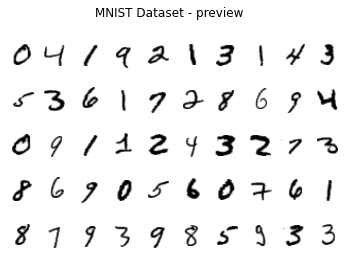

In [ ]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

ROW_IMG = 10
N_ROW = 5

fig = plt.figure()
for index in range(1, ROW_IMG*N_ROW+1):
  plt.subplot(N_ROW, ROW_IMG, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview')

In [ ]:
from torch.nn.modules.pooling import AvgPool2d
class LeNet5(nn.Module):
  def __init__(self, n_classes):
    super(LeNet5, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
        nn.Tanh()
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=n_classes)
    )
  
  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)
    return logits, probs

In [ ]:
torch.manual_seed(CFG['RANDOM_SEED'])

model = LeNet5(CFG['N_CLASSES'])
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
criterion = nn.CrossEntropyLoss()

15:12:55 --- Epoch: 0	Train loss: 0.2307	Valid loss: 0.0988	Train accuracy: 97.11	Valid accuracy: 96.82
15:13:19 --- Epoch: 1	Train loss: 0.0802	Valid loss: 0.0563	Train accuracy: 98.44	Valid accuracy: 98.21
15:13:42 --- Epoch: 2	Train loss: 0.0557	Valid loss: 0.0619	Train accuracy: 98.44	Valid accuracy: 98.01
15:14:06 --- Epoch: 3	Train loss: 0.0441	Valid loss: 0.0446	Train accuracy: 99.14	Valid accuracy: 98.64
15:14:30 --- Epoch: 4	Train loss: 0.0351	Valid loss: 0.0429	Train accuracy: 99.29	Valid accuracy: 98.66
15:14:55 --- Epoch: 5	Train loss: 0.0309	Valid loss: 0.0447	Train accuracy: 99.21	Valid accuracy: 98.65
15:15:18 --- Epoch: 6	Train loss: 0.0258	Valid loss: 0.0455	Train accuracy: 99.51	Valid accuracy: 98.72
15:15:42 --- Epoch: 7	Train loss: 0.0214	Valid loss: 0.0461	Train accuracy: 99.40	Valid accuracy: 98.57
15:16:06 --- Epoch: 8	Train loss: 0.0182	Valid loss: 0.0435	Train accuracy: 99.61	Valid accuracy: 98.89
15:16:29 --- Epoch: 9	Train loss: 0.0180	Valid loss: 0.0529	Trai

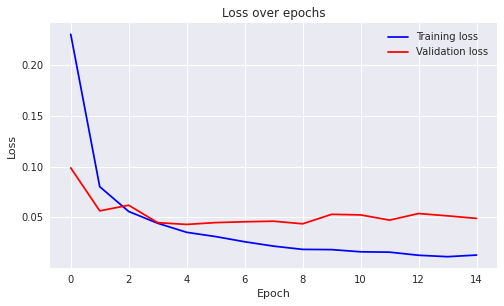

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, CFG['EPOCHS'], device)